In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.7 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from transformers import TFBertModel, BertTokenizer

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/commonlit/train.csv')

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [10]:
# Loading the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
# Preprocessing Text function
# - tokenizing using BERT tokenizer
def preprocess_text(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

In [12]:
# Preprocessing training and validation data
max_len = 256

train_input_ids, train_attention_masks = preprocess_text(train_data['excerpt'].values, tokenizer, max_len)
val_input_ids, val_attention_masks = preprocess_text(val_data['excerpt'].values, tokenizer, max_len)

train_labels = train_data['target'].values
val_labels = val_data['target'].values


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
# Defining and Compiling BERT model
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_masks = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

embeddings = bert_model(input_ids, attention_mask=attention_masks)[0]
output = tf.keras.layers.Dense(1, activation='linear')(embeddings[:, 0, :])

model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [16]:
batch_size = 16
epochs = 5

history = model.fit([train_input_ids, train_attention_masks], train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([val_input_ids, val_attention_masks], val_labels))

Epoch 1/5


142/142 [==============================] - 195s 1s/step - loss: 0.4822 - mean_squared_error: 0.4822 - val_loss: 0.3453 - val_mean_squared_error: 0.3453
Epoch 2/5
142/142 [==============================] - 146s 1s/step - loss: 0.2424 - mean_squared_error: 0.2424 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 3/5
142/142 [==============================] - 146s 1s/step - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.4807 - val_mean_squared_error: 0.4807
Epoch 4/5
142/142 [==============================] - 146s 1s/step - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.4744 - val_mean_squared_error: 0.4744
Epoch 5/5
142/142 [==============================] - 146s 1s/step - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.3109 - val_mean_squared_error: 0.3109


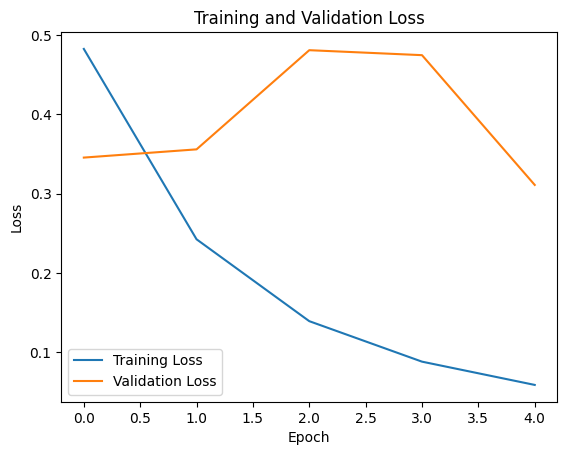

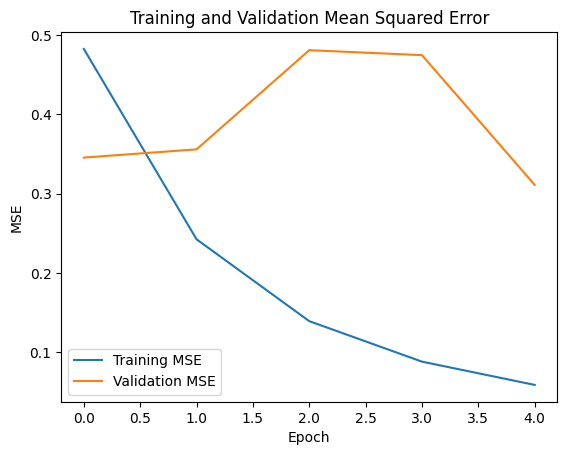

In [17]:
# Visualizing the loss and MSE overtime
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation mean squared error
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

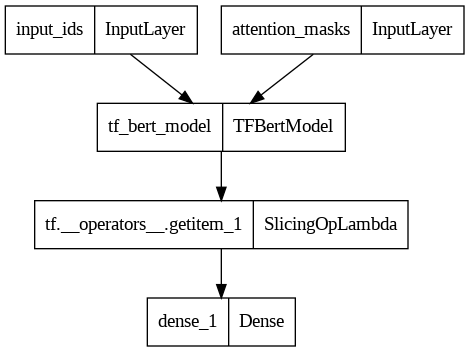

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# Testing the model with test data
test_df = pd.read_csv('/content/drive/MyDrive/commonlit/test.csv')

test_input_ids, test_attention_masks = preprocess_text(test_df['excerpt'].values, tokenizer, max_len)

test_preds = model.predict([test_input_ids, test_attention_masks])

results_df = pd.DataFrame({'id': test_df['id'], 'target': test_preds[:, 0]})
results_df.to_csv('results.csv', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 3s 3s/step


In [22]:
results_df.head()

,id,target
0,c0f722661,-0.241277
1,f0953f0a5,-0.095763
2,0df072751,-0.379236
3,04caf4e0c,-1.572214
4,0e63f8bea,-1.319421
